In [1]:
#contour=[]
#image_crop = []
# for j in range(len(images_train)):
#     contour.append(measure.find_contours(images_train[j],0.1))
#     c=0
#     for n,i in enumerate(contour[j]):
#         if len(i)>c:
#             c = len(i)
#             idx = n
#     for i in range(0,len(contour[j])):
#         if i!=idx:
#             ymin = int(round(min(contour[j][i][:,0])))
#             xmin = int(round(min(contour[j][i][:,1])))
#             ymax = int(round(max(contour[j][i][:,0])))
#             xmax = int(round(max(contour[j][i][:,1])))
#             images_train[j][ymin:ymax,xmin:xmax] = np.zeros(images_train[j][ymin:ymax,xmin:xmax].shape)
#     ymin = int(round(min(contour[j][idx][:,0])))
#     xmin = int(round(min(contour[j][idx][:,1])))
#     ymax = int(round(max(contour[j][idx][:,0])))
#     xmax = int(round(max(contour[j][idx][:,1])))
#     image_crop.append(images_train[j][ymin+1:ymax-1,xmin+1:xmax-1])

In [2]:
%matplotlib inline
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import ndimage
from skimage import measure

In [3]:
import os
print(os.listdir("../data"))

['train_labels.csv', '.DS_Store', 'train_images.npy', 'test_images.npy']


In [4]:
#Entire images and labels
images_train = np.load('../data/train_images.npy', encoding='latin1')
images_train = images_train[:,1]
images_train = images_train.tolist()
for i in range(len(images_train)):
    images_train[i]=images_train[i].reshape(100,100)
import csv
import string
with open('../data/train_labels.csv') as f:
    reader = csv.reader(f, delimiter=",")
    label_train = list(reader)   
del label_train[0]

In [5]:
#Carve around contours with maximum length. Noise around any enclosed contour is removed
contour=[]
image_crop = []
for j in range(len(images_train)):
    contour.append(measure.find_contours(images_train[j],0.1))
    c=0
    for n,i in enumerate(contour[j]):
        if len(i)>c:
            c = len(i)
            idx = n
    r_mask = np.zeros_like(images_train[j],dtype='bool')
    r_mask[np.round(contour[j][idx][:, 0]).astype('int'), np.round(contour[j][idx][:, 1]).astype('int')] = 1
    r_mask = ndimage.binary_fill_holes(r_mask)
    for k in range(0,r_mask.shape[0]):
        for l in range(0,r_mask.shape[1]):
            if r_mask[k,l]==0:
                images_train[j][k,l] = 0
    ymin = int(round(min(contour[j][idx][:,0])))
    xmin = int(round(min(contour[j][idx][:,1])))
    ymax = int(round(max(contour[j][idx][:,0])))
    xmax = int(round(max(contour[j][idx][:,1])))
    image_crop.append(images_train[j][ymin+1:ymax-1,xmin+1:xmax-1])

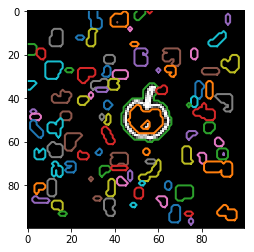

In [7]:
image1 = images_train[3]

# Display the image and plot all contours found
fig, ax = plt.subplots()
ax.imshow(image1, interpolation='nearest', cmap=plt.cm.gray)

for n, i in enumerate(contour[3]):
    ax.plot(i[:, 1], i[:, 0], linewidth=2)

['3', 'apple']
525


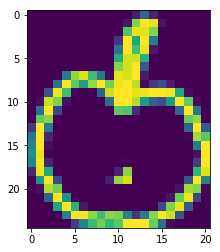

In [8]:
i=3
plt.imshow(image_crop[i])
print(label_train[i])
print(image_crop[i].size)

In [9]:
#Extract features from cropped image 
from skimage.transform import resize
from scipy.ndimage import gaussian_filter
from skimage import feature

image_height = []
image_width = []
image_norm = []
image_canny = []
for i in image_crop:
    image_height.append(i.shape[0])
    image_width.append(i.shape[1])
    image_norm.append(resize(i,(20,20), anti_aliasing = True, mode='constant'))
    image_canny.append(feature.canny(i))
    

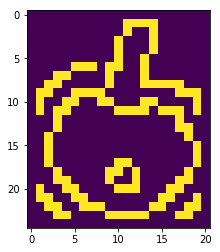

In [10]:
plt.imshow(image_canny[3])

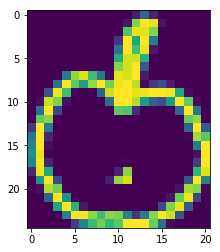

In [11]:
plt.imshow(image_crop[3])